In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Data from kaggle https://www.kaggle.com/datasets/nphantawee/pump-sensor-data
# saved in ./data
df = pd.read_csv('./data/sensor_pump.csv')

In [128]:
df.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [129]:
# have a brief look how the features are correlated
import plotly.graph_objects as go
fig = go.Figure(
    data=go.Heatmap(
        x=list(df.columns),
        y=list(df.columns),
        z=df.corr(),
        colorscale='viridis'
    ))
fig.update_layout(title='Feature Correlation', title_x=0.5)
fig.show()

In [130]:
# the categorical feature we want to predict is the machine_status
np.unique(df_i['machine_status'])

array(['BROKEN', 'NORMAL', 'RECOVERING'], dtype=object)

In [131]:
# we go with a small selection of features for now and ditch NaNs
df_i = df[['sensor_00','sensor_13','sensor_37','timestamp', 'machine_status']].dropna()
df_i.timestamp = pd.to_datetime(df_i.timestamp.values)

In [132]:
# try a straight-forward RFC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    df_i[['sensor_00','sensor_13','sensor_37']], df_i['machine_status'], random_state=42)

In [134]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [135]:
y_pred = rfc.predict(X_test)

In [136]:
np.count_nonzero(y_pred == 'NORMAL')

51496

In [138]:
# compute the confusion matrices (current label vs. others)
from sklearn.metrics import multilabel_confusion_matrix
y_unique = y_test.unique()

mcm = multilabel_confusion_matrix(y_test, rfc.predict(X_test), labels = y_unique)
print(mcm)

[[[ 1023    27]
  [    8 51469]]

 [[51469     9]
  [   27  1022]]

 [[52526     0]
  [    1     0]]]


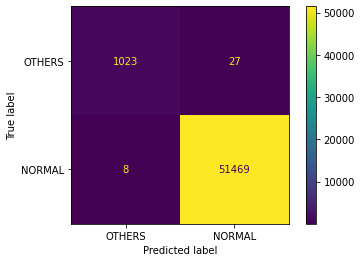

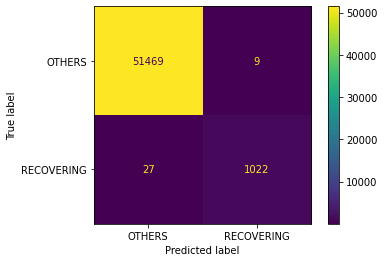

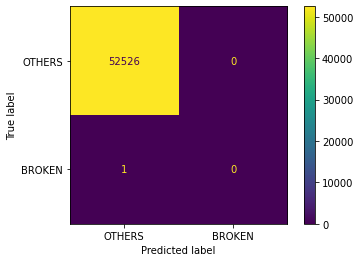

In [139]:
# and plot them
from sklearn.metrics import ConfusionMatrixDisplay
disp = []
for i in (0,1,2):
    disp.append(ConfusionMatrixDisplay(confusion_matrix=mcm[i], display_labels=['OTHERS', y_unique[i]]))
    disp[i].plot()

In [140]:
# turn it into an ONNX model
import onnxmltools
import skl2onnx
import onnx
import sklearn
import os
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from onnxruntime.capi.onnxruntime_pybind11_state import Fail as OrtFail
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes  # noqa
import onnxmltools.convert.common.data_types
from skl2onnx.common.data_types import FloatTensorType
import numpy
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from onnxruntime import InferenceSession
from skl2onnx import to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes  # noqa
from onnxmltools import __version__ as oml_version

In [141]:
# just a few steps
initial_type = [('float_input', FloatTensorType([None, 3]))]
onx = convert_sklearn(rfc, initial_types=initial_type,
                      target_opset=12)

with open("rfc_test.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [142]:
# visualize it
from mlprodict.onnxrt import OnnxInference
sess = OnnxInference(onx)
dot = sess.to_dot()
from jyquickhelper import RenderJsDot
RenderJsDot(dot)